In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib 
import numpy as np

In [2]:
jaspar_table_dir = Path('PATH-TO-ANALYSIS/misc/jaspar2020/')
tables_to_use = [jaspar_table_dir/'jaspar2020_mCtf.csv', 
                 jaspar_table_dir/'jaspar2020_nr_core_cplx.csv', 
                 jaspar_table_dir/'jaspar2020_nr_core_mono.csv']
tables = [ pd.read_csv(x, index_col=0) for x in tables_to_use]
tf_table = pd.concat(tables)
# tf_mapping = dict(zip(tf_table['matrix_id'],tf_table['tidy_name']))
# tf_mapping = dict(zip(tf_table['matrix_id'],tf_table['family']))
motif_name_map = dict(zip(tf_table['matrix_id'], tf_table['tidy_name']))
motif_family_map = dict(zip(tf_table['matrix_id'], tf_table['family']))

motif_official_names = dict(zip(tf_table['matrix_id'],tf_table['name'] ))

In [3]:
tf_cluster_df = pd.read_csv('PATH-TO-ANALYSIS/misc/jaspar2020/jaspar_core.cluster.csv', index_col=0)
cluster_dict = {}
for _, row in tf_cluster_df.iterrows():
    c = row['cluster']
    x,y = c.split('_')
    c = '_'.join([x,y.zfill(3)])
    motif_ids = row['motif_ids'].split(',')
    for motif_id in motif_ids:
        cluster_dict[motif_id] = c


In [4]:
sp_list = ['Human','Marmoset','Mouse']
nonn = '_noNonN'
hyp = 'hypo'
dmsn = '.dms1p'
# dmsn = ''
pq='p'

In [5]:
# sample_rename_dict = {'L5_IT':'L5 IT', 'L2_3_IT':'L2/3 IT', 'Lamp5':'Lamp5', 'Pvalb':'Pvalb', 
#                      'Vip':'Vip', 'Sst':'Sst', 'L6_CT':'L6 CT', 'L6_IT':'L6 IT', 
#                      'Sst_Chodl':'Sst Chodl', 'Sncg':'Sncg', 'L6b':'L6b', 'L6_IT_Car3':'L6 IT Car3', 
#                      'L5_6_NP':'L5/6 NP', 'L5_ET':'L5 ET', 'Meis2':'Meis2'}
samples = ['L5_IT', 'L2_3_IT', 'Lamp5', 'Pvalb', 'Vip', 'Sst', 'L6_CT', 'L6_IT', 
           'Sst_Chodl', 'Sncg', 'L6b', 'L6_IT_Car3', 'L5_6_NP', 'L5_ET', 
           #'Meis2',
          ]

In [6]:
ame_list = {}
for sp in sp_list:
    if sp not in ame_list:
        ame_list[sp] = {}
    for i,sample in enumerate(samples):
#         amedf = pd.read_csv(f'../cell_type_dmr_using_naive_mapping/{sp}/dmr/ame{nonn}/{sample}.{hyp}{dmsn}.ame.tsv', sep='\t', index_col=0)
        amedf = pd.read_csv(f'PATH-TO-ANALYSIS/{sp}/subclass/ame//{sample}.{hyp}{dmsn}.ame.tsv', sep='\t', index_col=0)
        amedf['log10(p-value)'] = np.log10(amedf['p-value']+1e-300)
        amedf['log10(p-value)'] = np.clip(amedf['log10(p-value)'], a_max=None, a_min=-300)
        amedf['log10(q-value)'] = np.log10(amedf['adj_p-value']+1e-400)
        amedf['log10(q-value)'] = np.clip(amedf['log10(q-value)'], a_max=None, a_min=-400)
        ame_list[sp][sample] = amedf

/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# fig, axes = plt.subplots(1,len(samples),figsize=(60,8))
totdf = []

for i,sample in enumerate(samples):
    if sample=='Meis2':
        continue

    indexes = set()
    dfs = []
    for j,sp in enumerate(sp_list):
        amedf = ame_list[sp][sample].set_index('motif_ID')
#         amedf = amedf.loc[tfids]
        amedf = amedf[['log2(TP/FP)',f'log10({pq}-value)']]
        amedf.columns = pd.MultiIndex.from_product([[sample],[sp],amedf.columns])
        dfs.append(amedf)
#                                                            ascending=True).iloc[:30].index)
    df = pd.concat(dfs,axis=1)
    totdf.append(df)
totdf = pd.concat(totdf, axis=1)

totdf.columns = totdf.columns.map(lambda x: '.'.join(x))
totdf = totdf.dropna()
totdf = totdf[~totdf.index.str.startswith('UN')]

totdf.index = totdf.index.map(lambda x: f'{cluster_dict[x]}-{x}')
totdf = totdf.sort_index()

/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [8]:
def _filter(pqvaldf, thresh=30):
    return pqvaldf[~(pqvaldf.min(1)>-abs(thresh))]

def _clip(pqvaldf, lower=None, upper=100):
    return pqvaldf.clip(lower, upper)

# def _collapse_tf(pqvaldf, keep_ratio=0.5):
    

def transform_0(pqvaldf):
    df = pqvaldf.copy().dropna()
    return \
        _clip(
        _filter( 
            df 
        ))
    
def transform_1(pqvaldf):
    df = pqvaldf.copy().dropna()
    return \
        _clip(
        _filter( 
            df 
        ,thresh=50)
        ,upper=100)


# profile details

In [9]:
pqvaldf = totdf[totdf.columns[totdf.columns.str.endswith(f'.log10({pq}-value)')]]
pqvaldf.columns = pqvaldf.columns.map(lambda x: x.replace(f'.log10({pq}-value)',''))
fcdf = totdf[totdf.columns[totdf.columns.str.endswith(f'.log2(TP/FP)')]]
fcdf.columns = fcdf.columns.map(lambda x: x.replace(f'.log2(TP/FP)',''))


In [10]:
plot_cols = [
             'L5_IT.Human', 'L5_IT.Marmoset', 'L5_IT.Mouse', 
             'L2_3_IT.Human', 'L2_3_IT.Marmoset', 'L2_3_IT.Mouse', 
             'L6_CT.Human', 'L6_CT.Marmoset', 'L6_CT.Mouse', 
             'L6_IT.Human', 'L6_IT.Marmoset', 'L6_IT.Mouse', 
             'L6b.Human', 'L6b.Marmoset', 'L6b.Mouse',
             'L6_IT_Car3.Human', 'L6_IT_Car3.Marmoset', 'L6_IT_Car3.Mouse', 
             'L5_6_NP.Human', 'L5_6_NP.Marmoset', 'L5_6_NP.Mouse', 
             'L5_ET.Human', 'L5_ET.Marmoset', 'L5_ET.Mouse',
    
             'Lamp5.Human', 'Lamp5.Marmoset', 'Lamp5.Mouse', 
             'Pvalb.Human', 'Pvalb.Marmoset', 'Pvalb.Mouse', 
             'Vip.Human', 'Vip.Marmoset', 'Vip.Mouse', 
             'Sst.Human', 'Sst.Marmoset', 'Sst.Mouse', 
             'Sst_Chodl.Human', 'Sst_Chodl.Marmoset', 'Sst_Chodl.Mouse',
             'Sncg.Human', 'Sncg.Marmoset', 'Sncg.Mouse', 
]

In [11]:
def plot_profile_summary(pvaldf, fcdf=None, ax=None):

    x, y = np.meshgrid(range(pvaldf.shape[0]), range(pvaldf.shape[1]), indexing='ij')
    for i in range(y.shape[1]):
        y[:,i] += i//3
    x, y = x.flatten(), y.flatten()

    if ax is None:
        plt.figure(figsize=(pvaldf.shape[1]//2+2, pvaldf.shape[0]//6))
#         print(pvaldf.shape[1]//2+2, pvaldf.shape[0]//7+2)
        ax = plt.gca()
        
    if fcdf is not None:
        ax.scatter(y,x,s=np.clip(-pvaldf.values.flatten(), 0, 50)**1.2,
                    c=fcdf.values.flatten(), cmap='viridis',vmin=0,vmax=1)
    else:
        ax.scatter(y,x,s=np.clip(-pvaldf.values.flatten(), 0, 50)**1.2, cmap='viridis',vmin=0,vmax=1)
    
    ax.set_xlim(min(y)-1, max(y)+1+3)
    ax.set_ylim(min(x)-1, max(x)+1)

    for i in range(3,max(x)+1,4):
        ax.axvline(i, 0.01, 0.99, color='#f0f0f0')

    ax.set_yticks(range(min(x),max(x)+1))
    # plt.gca().set_yticklabels(pvaldf.index.map(lambda x: x.split('|')[0]))
#     ax.set_yticklabels(pvaldf.index.map(lambda x: x.split('|')[0]))
    ax.set_yticklabels(pvaldf.index.map(lambda x: motif_official_names[x.split('-')[1]]))
    
#     ax.set_yticklabels(pvaldf.index)
    ax.set_xticks([])


In [12]:
def plot_color_column(color_df, s=70):
    plt.figure(figsize=(1, len(color_df)//6))
    ax = plt.gca()
    y=[0]*len(color_df)
    x = range(len(color_df))
    ax.scatter(y,x,marker='s',s=70, c=color_df.values,)

    ax.set_xlim(min(y)-1, max(y)+1)
    ax.set_ylim(min(x)-1, max(x)+1)

    ax.set_yticks(range(min(x),max(x)+1))
    # # plt.gca().set_yticklabels(pvaldf.index.map(lambda x: x.split('|')[0]))
    # ax.set_yticklabels(pvaldf.index.map(lambda x: x.split('|')[0]))

    # ax.set_yticklabels(pvaldf.index)
    ax.set_yticks([])
    ax.set_xticks([])

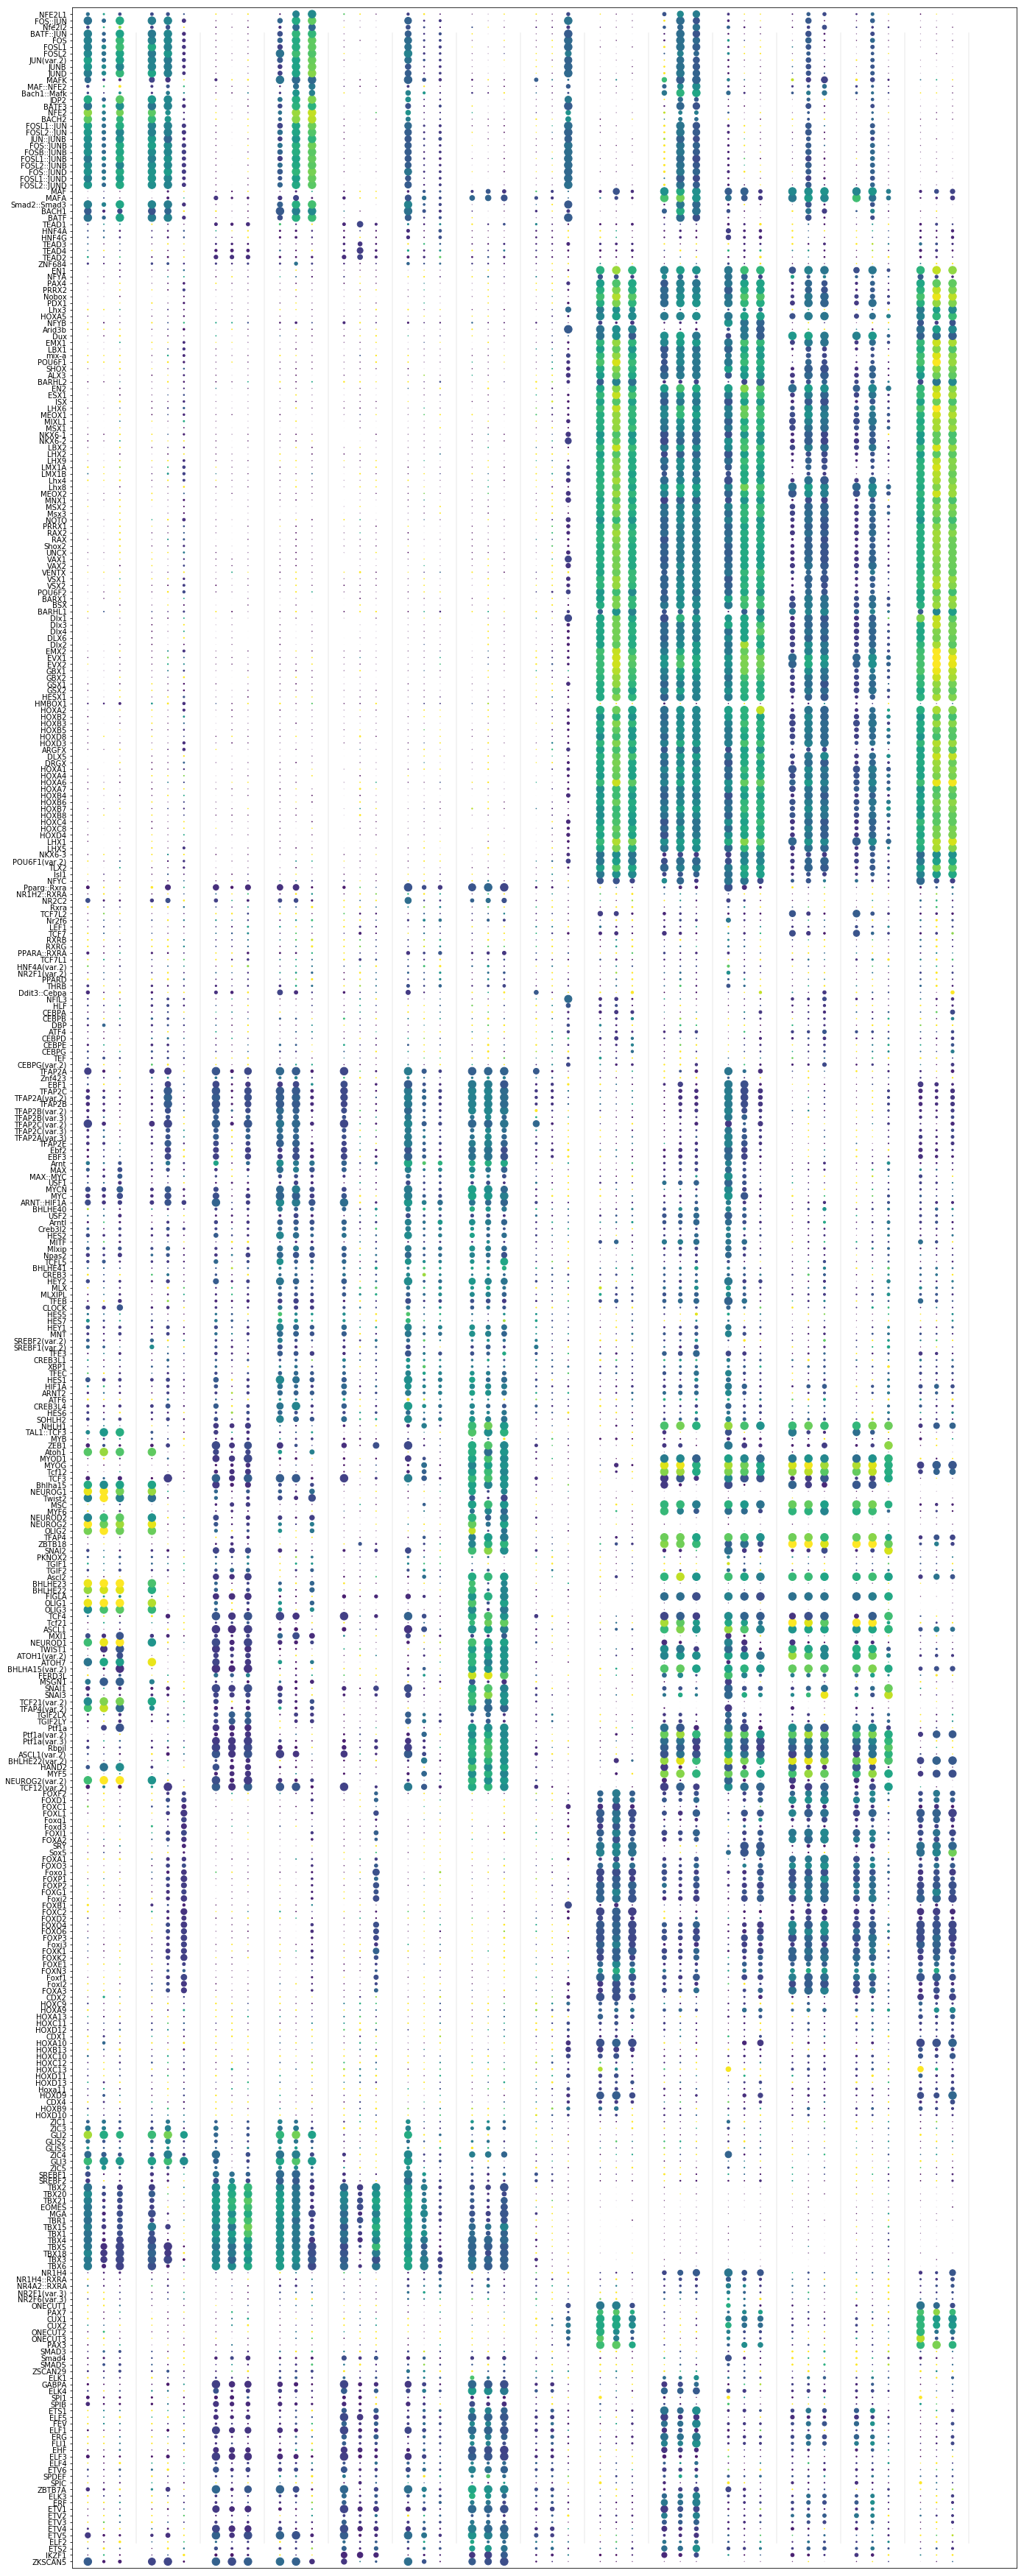

In [13]:
plot_profile_summary(pqvaldf[plot_cols].iloc[:389][::-1], fcdf[plot_cols].iloc[:389][::-1])


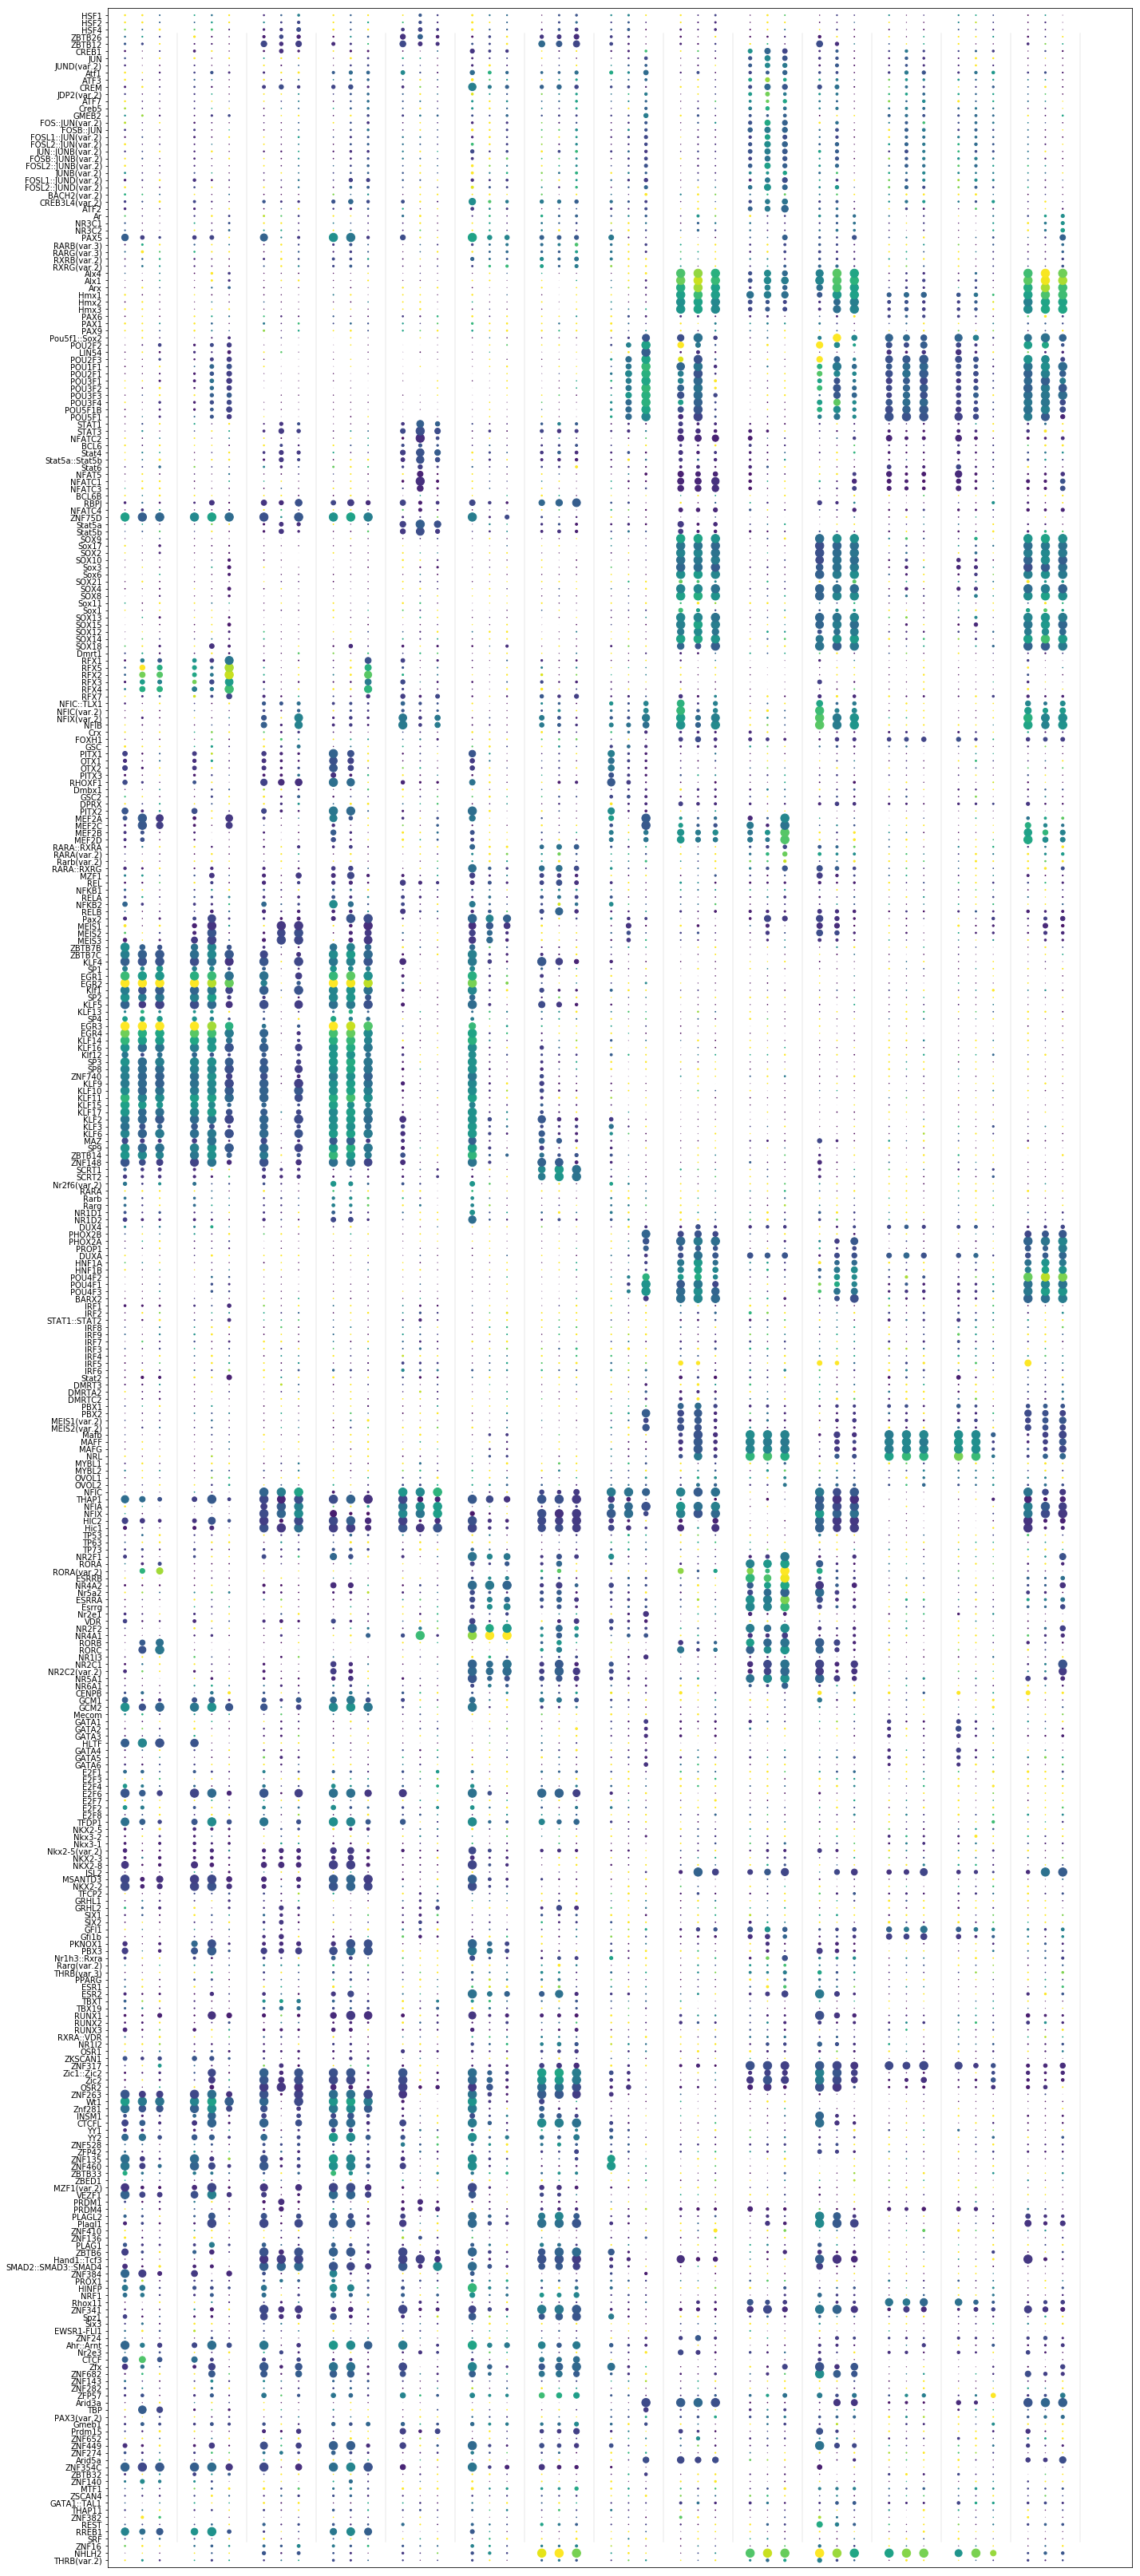

In [14]:
plot_profile_summary(pqvaldf[plot_cols].iloc[389:][::-1], fcdf[plot_cols].iloc[389:][::-1])


In [15]:
pqvaldf['cluster'] = pqvaldf.index.map(lambda x: x.split('-')[0]) 
fcdf['cluster'] = fcdf.index.map(lambda x: x.split('-')[0]) 

/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


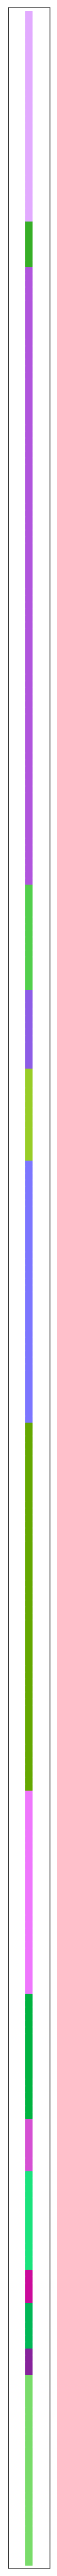

In [16]:
cluster_hue = ["#e2abff", "#36ae26", "#b055dd", "#52cf4c", "#8d5de6", "#98cd27", "#7c76ff", "#64a800", "#ef77fd", "#00b340", "#d550d3", "#1ae37c", "#cb0b9b", "#01b756", "#86239b", "#79dc6a", "#6736ac", "#bad139", "#0a8aff", "#d7bd00", "#0068cd", "#f2ad00", "#4847a5", "#91af00", "#ff70e2", "#379300", "#f49aff", "#008e1c", "#f81f6e", "#02b869", "#a30074", "#71dc7c", "#c4006c", "#02bf82", "#ff4482", "#00cca2", "#fd3f4d", "#5bdda4", "#c60046", "#02b084", "#bb0e08", "#01d3f7", "#e23a29", "#0297ec", "#e45716", "#03aee9", "#c03600", "#71b0ff", "#d97a00", "#8f92ff", "#ca9e00", "#6e3a95", "#a7d464", "#7a3786", "#e6c347", "#195394", "#ff8b2c", "#0176a6", "#ff6f39", "#00b2a4", "#a31b05", "#83c7ff", "#aa5400", "#aba6ff", "#989100", "#c1a2ff", "#286b00", "#ff6bb4", "#017b46", "#ff88d2", "#1b601d", "#fea9fc", "#597300", "#cabefc", "#a97b00", "#be9fd3", "#ffae4e", "#7d3b6d", "#c2cd6e", "#a50645", "#9dd496", "#8d2f61", "#cec97e", "#785683", "#ffa15e", "#00785f", "#ff8268", "#065f43", "#ff94a7", "#3a5c1a", "#edb5e1", "#776400", "#b97da1", "#4e571d", "#ff9d95", "#5c9571", "#9a2826", "#aec791", "#952c3d", "#a1a76f", "#913505", "#708451", "#ff956b", "#8c905a", "#a6637a", "#e0c387", "#80403b", "#f8ba7b", "#884000", "#c8837a", "#7e5100"]
cluster_color_df = pqvaldf['cluster'].apply(lambda x: cluster_hue[int(x.split('_')[1])-1] )

plot_color_column(cluster_color_df.iloc[:389][::-1])


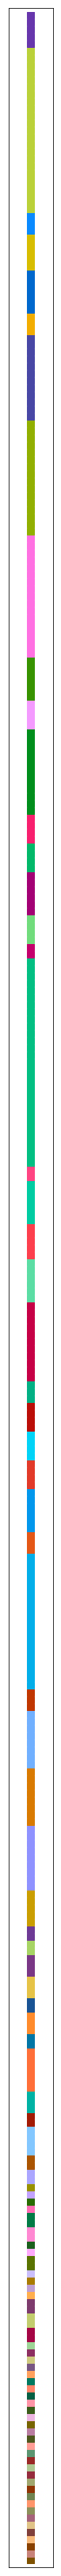

In [17]:
plot_color_column(cluster_color_df.iloc[389:][::-1])


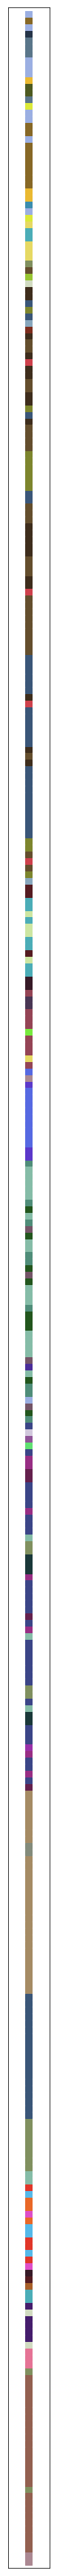

In [18]:
tf_family_hue = ["#493654", "#77ea3e", "#6826e2", "#dbe939", "#5b38ca", "#4eb934", "#ce3be7", "#60e072", "#9a30a9", "#98c532", "#a664e5", "#b7e477", "#4a2d99", "#eab931", "#5669e2", "#e6d963", "#de4ec7", "#68eaa5", "#e245a0", "#63a13a", "#451d6c", "#aeaf36", "#598eec", "#e96827", "#55b9e9", "#e13629", "#6ae7d3", "#e53872", "#39b993", "#982e84", "#3b8235", "#d580d5", "#22561d", "#786dc7", "#df8c31", "#3b4587", "#bb9538", "#291747", "#cde6a2", "#64204d", "#7fc082", "#a62d61", "#399161", "#ce414c", "#4badb7", "#b54223", "#95dde7", "#7d2e1e", "#4f80c3", "#7d852d", "#8f5498", "#cbc07b", "#1a182d", "#d1dbc1", "#371a27", "#e4ac76", "#253448", "#e77f5f", "#3b8dae", "#a85f29", "#9bafe2", "#876826", "#bc9adc", "#4d5a20", "#e57395", "#3d6947", "#e9aed3", "#273b20", "#d1c8dd", "#551c21", "#85bca7", "#944455", "#4f8d79", "#b86d90", "#80905f", "#7c72a2", "#644e2d", "#88a7bd", "#3e2d1c", "#e1b7a5", "#1a3839", "#d7867d", "#3a5678", "#a58b64", "#5a768a", "#936050", "#366564", "#ab8892", "#838b7b", "#745567"][::-1]

tmpdict1 = dict(zip(tf_table['matrix_id'], tf_table['family'].fillna('NaN')))
tmpdict2 = dict(zip(tf_table['family'].fillna('NaN').unique(), range(len(tf_table['family'].fillna('NaN').unique()))))

tf_family_color_df = pqvaldf.index.map(lambda x: tf_family_hue[tmpdict2[tmpdict1[x.split('-')[1]]]]  )

plot_color_column(tf_family_color_df[:389][::-1])


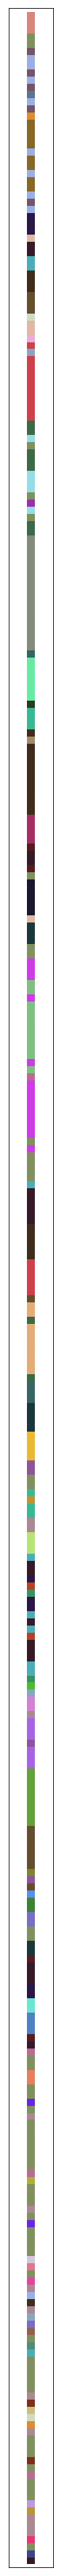

In [19]:
plot_color_column(tf_family_color_df[389:][::-1])
